# SOSP:  3 islands 2021

Last update:  2021-11-22

Whitney Tabor and Sandra Villata
University of Connecticut

Contact: whitney.tabor@uconn.edu, sandra.villata@uconn.edu (feel free to send questions or comments)

**Precis**

This file contains python code for implementing the simulations in 

> Villata, S. & Tabor, W. (2021). A self-organized sentence processing theory of gradience:
The case of islands. Cognition.

It is a jupyter notebook (juypter.org).  Anaconda (anaconda.com), among others, is a good platform for running Jupyter notebooks in python.  

This file and its accessories are located at github.com/WhitneyTabor

**Intro**

SOSP-GD (Self-organized sentence processing - grammar derived) is a differential equation model of sentence processing, derived from a probabilistic context free grammar (PCFG). The paper above focuses on gradience in islands. It notes an empirical contrast between English *whether* and *Complex NP (CNP)* islands on the one hand, and *because-Adjunct* islands on the other: the first two types, which we here view as cases of *Weak Islands*, show intermediate behaviors (intermediate acceptability, intermediate rates of linking filler and gap) compared to the last case, a *Strong Island*.  The paper claims that this difference stems from the ability of some parts of the structure of weak islands to be coerced into roles that allow linking of fillers and gap across island boundaries, while there are no such elements in strong islands.  

To formalize these claims, SOSP-GD works with treelets consisting of a mother node and a sequence of daughters. When a sentence is produced or comprehended, treelets associated with the words and possible phrases in the sentence interact dynamically to form a parse.  The treelets correspond to productions in a context free grammar (CFG).  The model claims that, when a language-user's experience with a sentence is not fully felicitous, what is happening is that some treelets in a parse tree are being *coerced* to play roles for which they are not optimally suited.  SOSP-GD distinguishes two forms of coercion:  in *interpretable coercion*, some role-forcing occurs but thematic constraints (a.k.a. the Theta Criterion) are still obeyed.  In *uninterpretable coercion*, thematic constraints are violated. The paper claims that the semi-successful parsing of weak islands involves interpretable coercion, while the failed parsing of strong islands involves uninterpretalbe coercion.  The paper makes arguments, based on specific syntactic and semantic analyses of the three island constructions involved, that interpretable coercion is available for whether- and CNP-islands, but is unavailable for *because*-adjunct islands.

The scripts here are concerned with one premise of this argument:  that, under the grammar of English posited in the paper, combined with the assumptions mae about which coercions violate thematic constraints and which do not, interetable coercion is available for whether- and CNP-island extractions, but only uninterpretable coercion is available for because-adjunct island extractions.  This is, in effect, a question about which parses are generated by a particular CFG, as explained below.  Thus, it is possible to evaluate the premise using standard computational linguistic tools.

The current scripts make use of the Python library, NLTK (Natural Language Toolkit---Bird, Loper, & Klein, 2009---see References below).  In fact, we built the simulations initially in Matlab, but since NLTK is open-source and more widely used in comptuational linguistics, we have chosen to provide this implemention in Python.  (There is one exception, viz. one part which we have not yet translated into Python---this is explained below.)

**SOSP-GD**

As outlined in the paper, the SOSP-GD derivation process is:

**PCFG $\rightarrow$ Extended CFG $\rightarrow$ Tree Harmony Values** + Tree Locations $\rightarrow$ Attractors $\rightarrow$ Dynamical Processing Model (= SOSP-GD)

The scripts here cover the first few steps of this process (shown in bold). 

We start by specifying a PCFG.  The production probabilities only matter later in the derivation process, so we could have left them out here (i.e., worked with just a CFG), but for consistency of formalism, we have included them. We then derive an Extended CFG--a CFG with associated *bonds* specifying productions are linked together into a tree. Each bond has an associated harmony value.  For a given string of interest, we determine all parse trees under the Extended CFG, along with its associated bond harmonies.  The harmony of each tree, which models the grammaticality of the corresponding parse, is calcuated as the product of its bond harmonies.  In the full model, the bond and tree harmonies range over [0, 1], but in this case, we are just concerned with whether or not each parse maintains or violates thematic constraints, so we work with binary values.

In [1]:
# Import libraries

import numpy as np
import nltk
import matplotlib
import pylab as plt
from nltk.corpus import treebank
import copy
import time
import networkx as nx

**-----Start of Function defintions-----**

In [2]:
def is_empty(generator):
    """Return true if a generator contains something, if not, return false"""
    
    for item in generator:
        return False
    return True

In [3]:
def get_ind(curritem, currlist):
    """Return index of item on list, else return -1"""

    try:
        currind = currlist.index(curritem)
        return currind
    except ValueError:
        return -1

In [4]:
def listmatch(list1, list2):
    """Return (match, nomatch) where match is a list of the indices of items on list1 which are also on list2
       and nomatch is a list of items on list1 which are not on list2"""
    
    match = []
    nomatch = []
    for icount in range(len(list1)):
        currind = get_ind(list1[icount], list2)
        if currind >= 0:
            match.append([icount, currind])
        else:
            nomatch.append(icount)
    
    return (match, nomatch)

In [5]:
def load_string(filename):
    """Load a text file as a single string"""
    
    fpt = open(filename, 'r')
    
    fstring = fpt.read()
    
    fpt.close()
    
    return fstring

In [6]:
def load_stringgram(infile):
    """Load a grammar, specified as a single string, from a file"""
    
    fpt = open(infile, 'r')
    tstring = fpt.read()
    fpt.close()
    
    grammar = nltk.PCFG.fromstring(tstring)
    
    return grammar

In [7]:
def strip_probs(pcfgplist):
    """From a list of probabilistic NLTK productions, form a list of (non-probabilistic) productions"""
    
    cfgplist = []
    for currprod in pcfgplist:
        newprod = nltk.grammar.Production(currprod.lhs(), currprod.rhs())
        cfgplist.append(newprod)
        
    return cfgplist

In [8]:
def readtreefile(treefile):
    """Import NLTK trees from a file (which lists them in stringform)"""
    
    fpt = open(treefile, 'r')
    
    tcount = 0
    imptrees = []
    for line in fpt:    
        if not len(line.strip()) == 0: # Empty line
            if not(line[0] == '%'): # Comment line
                tcount += 1
                imptrees.append(nltk.tree.Tree.fromstring(line))
                
    return imptrees

In [9]:
def load_bh(bhfile):
    """Load bond specifications and their harmonies from a file"""
    
    bhlist = []
    
    fpt = open(bhfile, 'r')
    lcount = 0
    for line in fpt:
        lcount += 1
        
        if not len(line.strip()) == 0: # Empty line
            if not(line[0] == '%'): # Comment line
                
                wordlist = line.split()
                if not(len(wordlist) == 4):
                    print('Error (line', lcount, '):', line)
                    return
                else:
                    bhlist.append([[wordlist[1], wordlist[3]], float(wordlist[0])])
            
    return bhlist

In [10]:
def build_sosp_gram(base_gram, bhlist):
    """Build an sosp extend CFG, namely, a tuple, consisting of an NLTK grammar, 
       a list of production types (rule vs bond), and a list
       of production harmonies"""
    
    # Note:  SOSP-GD distinguishes treelets from bonds, and defines a
    #        parse as a set of treelets with bonds connecting them.  This
    #        distinction is not made in standard NLTK, so the current scripts
    #        implement both treelets and bonds as productions, and use 
    #        the indexing list, prod_types, to keep track of which productions
    #        are treelets and which are bonds.  Under this conflation, it is
    #        convenient to assign a harmony value of 1 to each treelet, even
    #        though, in vanilla SOSP-GD, harmonies are only associated with 
    #        bonds, not with treelets. 
    
     # Start with the productions in the grammar
    prods = copy.deepcopy(base_gram.productions())
    
    # Construct prod_types, the list of production types (rule vs bond) 
    prod_types = [0]*len(prods) + [1]*len(bhlist) # 0 indicates rule status, 1 indicates bond status
    # Start to construct prod_harms, the list of harmonies of the bonds
    prod_harms = [1]*len(prods) # Consider all rules to be "bonds" of harmony 1
    # Add the bonds as productions
    for bhind in range(len(bhlist)):
        lhs = nltk.grammar.Nonterminal(bhlist[bhind][0][0])
        rhs = nltk.grammar.Nonterminal(bhlist[bhind][0][1])
        currprod = nltk.grammar.ProbabilisticProduction(lhs, [rhs], prob=0.0) 
                # 0 is the production probability (not needed here, but added for consistency)
        prods.append(currprod)
        prod_harms.append(bhlist[bhind][1])
        
    # In case the parsing algorithm used below attends to the probabilities, make them all uniform
    # in support of exhaustive parse discovery (Note:  This seems to improve S2 below but not S3)
    cfg_prod_list = strip_probs(prods)
    Root = nltk.Nonterminal('Root')
    sosp_gram= nltk.induce_pcfg(Root, cfg_prod_list)
                         
    return (sosp_gram, prod_types, prod_harms)

In [11]:
def nobtrains(currtree, cfg_prod_list, prod_types, prevtype):
    """Return true if the parse contains no bond-trains, false it has at least one"""
    
    # A bond-train is a section of the parse where a bond attaches directly to another bond
    # Eg., nobtrains(currtree, cfg_prod_list, prod_types, 0) # Note: set prevtype = 0 at start
    
    nbts = True
    if hasattr(currtree, 'productions'):
        rootprod = currtree.productions()[0]
        currind = cfg_prod_list.index(rootprod)
        currtype = prod_types[currind]
        if (currtype == 1) & (prevtype == 1): # Found a bond-train
            nbts = False
            return nbts
        else: # Recurse
            for stcount in range(len(currtree)):
                if not(nobtrains(currtree[stcount], cfg_prod_list, prod_types, currtype)):
                    nbts = False
    
    return nbts

In [12]:
def harmony(tree, cfg_prod_list, prod_harms):
    """Calculate tree harmony as the product of its production harmonies"""
    
    # Note:  technically, a tree's harmony is the product of its bonds' harmonies,
    #        but since we have assigned a harmony of 1 to each treelet, for convenience,
    #        we calculate tree harmony by multiplying all the production harmonies
    #        together (the extra 1s do not affect the outcome).
    
    if hasattr(tree, 'productions'):
        rootprod = tree.productions()[0]
        currind = cfg_prod_list.index(rootprod)
        treeharm = prod_harms[currind]
        for stcount in range(len(tree)):
            treeharm = treeharm*harmony(tree[stcount], cfg_prod_list, prod_harms)
    else:
        treeharm = 1
    
    return treeharm

**-----End of Function definitions-----**

**Build an Extended CFG**

We define the SOSP-GD parse set of string, **s**, associated with a (P)CFG, **base_gram**, to be the set of trees that can be formed by starting with a treelet whose mother is the root node of **base_gram** and attaching (i.e., "bonding") treelet mothers below to daughters above until the terminal nodes of the tree, taken in order from left to right are **s**.  Unlike in a standard grammar model, it is not required that the label of the mother below match the label of the daughter above. Each bond is associate with a harmony value in [0, 1].  The grammatical bonds have harmony 1 (or nearly 1) and the mismatch bonds (called "coercions") have lower harmony values indicating their degree of mismatch. The harmony of the resulting tree is the product of the harmonies of its bonds.  Although we do not implement the full model here, in the full model, parses correspond to attractive fixed-points of the dynamical system, with higher harmony parses having wider basins of attraction. Processing is modeled as noisy integration of the dynamics, so the system preferentially visits fixed points associated with high harmony parses.  

Of course, there are many possible mismatched bonds and if they are all included, computing all the parses is intractable. However, because the full model mainly visits higher harmony attractors, we can achieve a reasonble approximation of the full dynamics by including only relatively high-harmony parses in the computation.

We do that here by considering only a few coercions.  In the implementation below, the focused coercions are listed in a file with "bh-" in its filename (for "bond harmony").  Each line in a bh- file contains a bond-harmony value, followed by the label of a daughter above and a mother below.  Since bonds between daughters above and mothers below can be thought of as unary-branching rules in a CFG, we implement them that way here, supporting the use of NLTK parsing algorithms to discover ways of parsing trees with coercions in them.

We thus form an *Extended CFG* by adding productions to the original (P)CFG, one added production for every coercion specified.  An Extended CFG consists of a grammar (**sosp_gram**), a list of production types (**prod_types**), and a list of production harmony values (**prod_harms**). To keep track of which productions in **sosp_gram** are from the original grammar and which are bond-specifications, the list, **prod_types**, has an entry for each production of **sosp_gram**.  This entry is 0 for original productions and 1 for bonds.   For an original rule, the **prod_harms** value is 1 (see note above in the definition of build_sosp_gram). For a bond, the **prod_harms** value is 1 if it does not violate the Theta Criterion and 0 if it does (in the full implementation, these numbers can also be intermediate between 0 and 1).

Once the Extended CFG has been assembled, the next step is to use it to parse the sentences of interest.

Note: normally, one would specify a language model with general coverage, and then specify a string to parse.   In this case, because of some sensitivities of NLTK parsers (see discussion below), we need to know which string is being parsed up front to configure the language model in a way that achieves sufficiently comprehensive parsing. This what happens next:

In [13]:
# String to parse

#sentence = "whichreport report hear that report love p".split()
sentence = "whichreport report wonder whether report love p".split(); simlabel = 'whether extractions'
    # Whether island extr
#sentence = "whichreport report hear report that report love p".split(); simlabel = 'CNP extractions'
    # CNP island extr
#sentence = "whichreport report sleep because report love p".split(); simlabel = 'because-adjunct extractions' 
    # Adjunct island extr

Next, load the base (P)CFG and the bond harmony list, and build an extended CFG. 

In [14]:
# Load the base (P)CFG as an NLTK grammar

pcfginfile = 'gram3islands.pcfg'
base_gram = load_stringgram(pcfginfile)

# Load the list of coerced bond harmonies
# Villata & Tabor (2021) report three successive simulations:
#       S1. No coercions
#       S2. Only high harmony coercions
#       S3. Many coercions, including a number of low-harmony coercions (Note: even these
#           so-called "low-harmony" coercions, although they violate thematic constraints,
#           don't have rock-bottom harmony because they stay within grammatical classes. This
#           is the motivation for including them here. Under SOSP-GD, harmony values are 
#           hypothesized to reflect distributional similarity in usage, and members of the same
#           grammatical class tend to occur in similar environments even when they are thematically
#           incongruous.)
#bhfile = 'bh-no-coercions-all-types.txt' # S1:  standard grammatical processing
#bhfile = 'bh-high-coercions-all-types.txt' # S2:  include only relatively high harmony coercions 
#bhfile = 'bh-many-coercions-cnp.txt' # S3: include high and relatively low harmony coercions---complex np case
bhfile = 'bh-many-coercions-whether-adjunct.txt'
                          # S3: include high and relatively low harmony coercions---whether and because-adjunct cases
bhlist = load_bh(bhfile)

# Integrate base_gram with the coercions to form the Extended CFG
(sosp_gram, prod_types, prod_harms) = build_sosp_gram(base_gram, bhlist)

# Form a list of the productions in sosp_gram without their associated probabilities (will be useful later)
cfg_prod_list = strip_probs(sosp_gram.productions())

The next step is to find parses generated by the Extended CFG. Although exhaustive parsing in general is intractable, for the case at hand, where we consider a relatively small set of coercions, we can compute all parses for the examples of interest.  For the most liberal coercion-set discussed in Villata & Tabor (2021), the parse counts are as follows:

| String | Number of parses |
| :- | -: |
| whether-island extraction | 21 |
| CNP-island extraction | 26 |
| adjunct-island extraction | 21 |

We discovered these values using a parser written in Matlab. In Appendix below, we explain how we established these counts.  

This information turned out to be helpful to know for the NLTK implementation because the NLTK parsers do not consistently succeed in finding all the parses.  We guess that this stems from some triaging, perhaps not exploring all branches to reduce processing time (?). To give a concrete example, the file bh-many-coercions-cnp.txt leads to an extended grammar (call it "sosp_gram_cnp") whose rule set is a proper superset of the rule set produced by bh-many-coercions-whether-adjunct.txt ("sosp_gram_wa"). Nevertheless, every NLTK parser we tried failed to find all 21 parses for whether-extractions when using sosp_gram_cnp, but it found them all uing sosp_gram_wa with a Left Corner parser.  (We tried all the parsers mentioned at https://www.nltk.org/howto/parse.html).  If anyone knows how to configure an efficient NLTK parser so it parses exhaustively please let us know: whitney.tabor@uconn.edu, sandra.villata@uconn.edu.  Thanks!

In [15]:
# Set up the parser and a generator for parses of the current sentence

# Left Corner Parser
parser = nltk.parse.LeftCornerChartParser(sosp_gram)
cp = parser.chart_parse(sentence)
parseout = list(cp.parses(sosp_gram.start()))

In [16]:
# Compute all parses

pcount = 0
treelist = []
for tree in parseout:
    pcount += 1
    treelist.append(tree)
    #print(tree)
print('Number of parses found:  ', pcount)

Number of parses found:   959


At this point, the system may have found some parses, but not all of them are necessarily Extended CFG parses.  The issue is that from the standpoint of SOSP-GD, bond productions are not grammar rules of the Extended CFG---they are just a way of implementing coercions.  Formally, this means that they should never be used in succession:  a coercion cannot actually license another coercion as its "mother below".  We thus define a *bond-train* as a part of a parse in which a bond attaches to another bond without any intervening rule productions.  We want to restrict attention to just those parses that have no bond-trains.

There also is one other consideration which is sensible to raise at this stage.  It is possible for a CFG to support *cyclic non-branching domination*. This is occurs when a node in a tree dominates (immediately or distantly) a node with the same label and there are no branching attachments between the two of them. A sequence of nodes between two such identical nodes is called a *cycle* (technically, there must be no other copies of the end-nodes among the intervening nodes, but this property does not matter for present purposes).  If a nonbranching cycle exists in a parse of a sentence, then the sentence has infinitely many parses corresponding to different numbers of iterations of the cycle.  Generally, we are not interested in such cyclic parses.  Since bond harmonies are multiplied to compute tree harmonies, for any parse of a string that contains a cycle, there is always another, smaller parse of the same string with equal or higher harmony (we assume that terminal nodes cannot branch).  Thus, if we are interested in only the best parses, we can afford to ignore parses with cycles.  Ignoring these also makes the implementation more tractable.  Thus, in generally, it would be sensible, at this point, to check for cycles.  However, in the present case, it turns out that the Extended CFG generates no cyclic parses (see Appendix), so we skip this step here.

In [17]:
# Select parses that have no bond-trains (sections where a bond links directly to another bond)

sublist = []
subcount1 = 0
for tree in treelist:
    if nobtrains(tree, cfg_prod_list, prod_types, 0):
        sublist.append(tree)
        subcount1 += 1
print('Number of parses without bond-trains: ', subcount1)

Number of parses without bond-trains:  21


In [18]:
# Print the parses found

for tind, tree in enumerate(sublist):
    print()
    print(tind)
    print(tree)


0
(Root
  (WhQ
    (Whreport whichreport)
    (Smax/whreport
      (S/whreport
        (NPreport (Nreport report))
        (VP/whreport
          (Vhearsent (Vwonder wonder))
          (CPthat/whreport
            (Cthat (Cwhether whether))
            (S/whreport
              (NPreport (Nreport report))
              (VP/whreport (Vtrans love))))))))
  (RootLex p))

1
(Root
  (WhQ
    (Whreport whichreport)
    (Smax/whreport
      (S/whreport
        (NPreport (Nreport report))
        (VP/whreport
          (Vhearsent (Vwonder wonder))
          (CPthat/whreport
            (Cthat (Cwhether whether))
            (S/whreport
              (NPreport (Nreport report))
              (VP/whreport (VP (Vintrans (Vtrans love))))))))))
  (RootLex p))

2
(Root
  (WhQ
    (Whreport whichreport)
    (Smax/whreport
      (S/whreport
        (NPreport (Nreport report))
        (VP/whreport
          (Vhearsent (Vwonder wonder))
          (CPthat/whreport
            (Cthat (Cwhether whether))


For the various cases of interest, the numbers generated by the next-to-last window correspond to part of the data reported in the paper. The following table summarizes. Simulation S1 tested parsing with the original grammatical-only (P)CFG, S2 tested with a few, high-harmony coercions permitted, and S3 tested with many high- and low-harmony coercions permitted (these can each be run here by selecting the appropriate bh- file above).

| Simulation | String | Number of parses found | bh-file |
| :- | :- | -: |
| S1 | whether-island extraction | 0 | bh-no-coercions-all-types |
| S1 | CNP-island extraction | 0 | bh-no-coercions-all-types |
| S1 | adjunct-island extraction | 0 | bh-no-coercions-all-types |
| S2 | whether-island extraction | 1 | bh-high-coercions-all-types |
| S2 | CNP-island extraction | 1 | bh-high-coercions-all-types |
| S2 | adjunct-island extraction | 0 | bh-high-coercions-all-types |
| S3 | whether-island extraction | 21 | bh-many-coercions-whether-adjunct |
| S3 | CNP-island extraction | 26 | bh-many-coercions-cnp |
| S3 | adjunct-island extraction | 21 | bh-many-coercions-whether-adjunct |

The results are exhaustive in all cases.  As noted in the paper, when viewed in the context of full SOSP-GD, S1 and S2 fail to capture the gradient grammaticality data for the cases at hand.  S2 comes close in that it finds relatively high harmony parses for whether and CNP islands but it fails on the because-adjunct cases:  if the model generates no parses for a given string, then it predicts that in processing, the string will be perceived as a different string, generally one with high grammaticality.  This is clearly inaccurate for *because*-adjunct islands.

Simulation S3 is therefore the most promising version of the model.  However, to fully determine if the S3 results align with the empirical data, we need to consider the thematic statuses of the parses found.  The empirical data indicate that there should be at least one thematically coherent parse for whether islands and for CNP islands, and there should be none for *because*-adjuncts. To assess this, we need to calculate the tree harmonies for each of the parses.  

For this final assesment of the simulation, there is a detail of the corecion values that it is important to note:  the paper hypothesizes that CNP extractions are parsable because a phrase like "hear the report (that...)" is semantically very close to "hear (that...)".  This motivates assigning a relatively high harmony value to the coercion [Vhearsent : VP] precisely in cases where VP expands to "hear the report".  The grammars at hand have no easy mechanism for implementing this context-sensitivity (though we can write algorithm that implements it for the full SOSP-GD derivation). To easily approximate the correct constraints here, we assigned [Vhearsent : VP] a harmony of 1 in the CNP simulation and a harmony of 0 in the whether and adjunct simulations. 

In [19]:
# Check parse harmonies

sublistharms = []
for currtree in sublist:
    sublistharms.append(harmony(currtree, cfg_prod_list, prod_harms))
print('Parse harmonies for ', simlabel, ':')
print(sublistharms)

# Count the relatively high harmony cases
decentharmonycount = sublistharms.count(1.0)
print('Number of relatively high harmony trees for ', simlabel, ':', decentharmonycount)

Parse harmonies for  whether extractions :
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of relatively high harmony trees for  whether extractions : 1


In [20]:
# Print the relatively high harmony cases
print('Relatively high harmony parses: (', simlabel, ')')
print()
for tind, currtree in enumerate(sublist):
    if sublistharms[tind] == 1.0:
        print('Tree number', tind)
        print(sublist[tind])

Relatively high harmony parses: ( whether extractions )

Tree number 0
(Root
  (WhQ
    (Whreport whichreport)
    (Smax/whreport
      (S/whreport
        (NPreport (Nreport report))
        (VP/whreport
          (Vhearsent (Vwonder wonder))
          (CPthat/whreport
            (Cthat (Cwhether whether))
            (S/whreport
              (NPreport (Nreport report))
              (VP/whreport (Vtrans love))))))))
  (RootLex p))


The following table summarizes the results for S3:

| String | Number of parses | Number of thematically coherent parses |
| :- | :- | -: |
| whether-island extraction | 21 | 1 |
| CNP-island extraction | 26 | 1 |
| adjunct-island extraction | 21 | 0 |

Indeed, while whether-extractions and CNP-extractions each have one thematically coherent parse, *because*-adjunct-extractions have none.  The coherent parse found for whether-extractions (parse 0 of the relevant sublist) corresponds to the analysis in Figure 7 of the paper, and the coherent parse found for CNP-extractions (parse 3) corresponds to the analysis in Figure 9.  Regarding the because-adjunct sentence, incoherent parse 20 corresponds to Figure 11 and incoherent parse 0 corresponds to example (21).

### Appendix

This appendix is concerned with making sure the search for parses is exhaustive in the sense that it finds all parses of interest.  If the number of parses is finite and tractable, it should find all of them.  If it is infinite, but only a tractable finite number are noncyclic, then it should find those.  If it is infinite and there is an infinite or intractable number of noncyclic parses, then its should find the best ones.

It turns out that the present simulation fits the first description.  For each string of interest, there are only a small number of legitimate parses of the Extended CFG.  Here, when we refer to the Extended CFG, we mean the SOSP-GD grammar in which rules and bonds are different types of objects (and bonds cannot attach directly to other bonds).  We established tree counts by calculating a maximal tree height for noncyclic trees under the Extended CFG and then running a parser (written in Matlab) on the target sentences that exhaustively searched for trees up to the maximal height. 

To determine the maximal height, we reasoned as follows:  under binary branching grammars like gram3islands.pcfg, for a sentence of length $n$, the tree must include exactly *n-1* branching nodes.  If these are chained together for maximal height, the tree must have height at least *n*.  In addition, a tree can be taller than *n* if the branching nodes are joined by sequences of nonbranching nodes or if they dominate dangling sequences of nonbranching nodes.  However, if we do not want any cyclic sequences, then these intervening and dangling sequences are limited to the non-re-entrant sequences that can be formed with the nonbranching rules of the grammar. Thus we can write the height of the highest possible tree as:

 $H = n + I + D$
 
where *I* is the maximum number of levels that can be added by intervening sequences, and *D* is the maximum number of levels that can be added by dangling sequences.

To evaluate *H*, we formed the directed graph, NBPG ("Non-branching production graph"), determined by just the non-branching rules of the grammar. We refer to paths between branching nodes as *I-paths* and to dangling paths as *D-paths*. We define the length of an I-path or D-path with k nodes to be k-1.

A first, simplifying observation is that this graph has no cyclicity.  This is why we did not need to check for it when we pared down the set of parses above.

Regarding the D-paths, the worst case scenario is that the longest possible D-path dangles off the lowest branching node.  (Note that if similarly-long D-paths dangle off of other nodes, they will not increase *H*).  Therefore *D* = the length of the longest possible D-path. In the present case, it turns out to be easy to evaluate $D$ from NPBG (see the image generated by the code below):  the D-paths are precisely the paths that end in lexical elements (shown in uppercase italic font).  Their maximum length is 2 (this can be determined by careful inspection of the diagram), so 

$D = 2$ 

Regarding the I-paths, these conveniently show up in NBPG as isolated components that have no lexical member.  In principle, there could be one of these between every successive pair of branching nodes (hence *n-2* of these).  However one can see from the plot that the only such components are at the clause level (rules with 'CP' or 'S' mothers). Because the coercions under consideration here never cross class membership boundaries, the grammatical principle that each clause is headed by a unique verb holds, even under the Extended CFG. Therefore, the number of I-paths that augment the height can be at most 2 since the test sentences all have two verbs.  It is evident from the diagram below that the I-paths can have length at most 1. Therefore,

$I = 2\cdot 1 = 2$
 
For the whether- and adjunct-strings, which are 7 words long, this gives *H = 7 + 2 + 2 = 11*.  For the CNP case, which is 8 words long, this gives *H = 8 + 2 + 2 = 12*.  We therefore ran the parser on each string, terminating paths that led to *H* greater than the relevant value and found the tree counts reported above. 

In [21]:
### Generate the graph of nonbranching rule sequences

## Cull nonbranching productions from base_gram
base_prods = base_gram.productions()

nodelabels = []
nodelabelcolors = []
edgelabels = []
for prod in base_prods:
    rhs = prod.rhs()
    if len(rhs) == 1: # nonbranching
        mothersymbol = prod.lhs().symbol()
        if type(rhs[0]) == str: # lexical node
            daughtersymbol = rhs[0]
            daughtersymbol = '$' + daughtersymbol.upper() + '$'
            #nodelabels.append('+LEX' + daughtersymbol)
        else: # complex node
            daughtersymbol = rhs[0].symbol()
            #nodelabels.append(daughtersymbol)
        edgelabels.append([mothersymbol, daughtersymbol])
        nodelabels.append(mothersymbol)
        nodelabels.append(daughtersymbol)
        
nodelabels = list(np.unique(np.array(nodelabels)))

## Add the coercions

# Load the full list of coercions
bhfile = 'bh-many-coercions-cnp.txt' # This file, the one used for CNP islands, includes all coercions of interest
bhlist = load_bh(bhfile)

# Add coercions as daughters and coercions as mothers
newedgelabels = []
for coer in bhlist:
    codaughterabove = coer[0][0]
    comotherbelow = coer[0][1]
    colabel = coer[0][0] + '-' + coer[0][1]
    nodelabels.append(colabel)
    for edge in edgelabels:
        # Coercions as daughters
        if edge[1] == codaughterabove: # Second element of edge must match lhs of coercion
            newedgelabels.append([edge[0], colabel])
        # Coercions as mothers
        if edge[0] == comotherbelow: # First element of edge must match rhs of coercion
            newedgelabels.append([colabel, edge[1]])
        
edgelabels.extend(newedgelabels)

# Make nodes from the labels (there's probably a more efficient way to do this)
nnodes = len(nodelabels)
nodelist = list(range(0, nnodes))
    
# Make edges
edgelist = []
for elabel in edgelabels:
    mothersymbol = elabel[0]
    daughtersymbol = elabel[1]
    edgelist.append([nodelabels.index(mothersymbol), nodelabels.index(daughtersymbol)])
    
# Make the label list (a dictionary)
labels = dict()
for nind, currlab in enumerate(nodelabels):
    labels[nind] = currlab
    
# Make the graph
NBPG = nx.DiGraph()
NBPG.add_edges_from(edgelist)

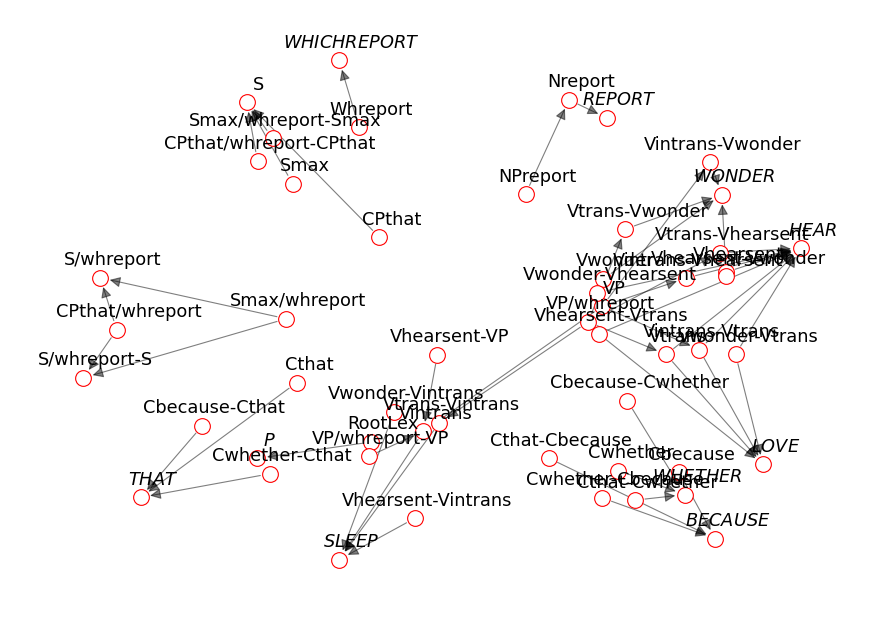

In [23]:
## Plot the graph

# Node positions
#currseed = np.random.randint(99999999)
currseed = 33393661 # This seed for the stochastic annealing produces a reasonable image
pos = nx.spring_layout(NBPG, k=0.15, iterations=20, seed=currseed)

# Label positions
xdisp = 0.03
ydisp = 0.06
cdisp = np.array([xdisp, ydisp])
lpos = copy.deepcopy(pos)
for key in pos.keys():
    lpos[key] += cdisp

## Draw
plt.figure(figsize = (14, 10), dpi = 80)
# Draw nodes
nodedisplay = nx.draw_networkx_nodes(NBPG, pos, nodelist = nodelist, node_color='white', node_size=200)
nodedisplay.set_edgecolor('red')
# Draw edges
nx.draw_networkx_edges(NBPG, pos, width=1.0, alpha=0.5, arrowsize = 20)
# Add labels
nx.draw_networkx_labels(NBPG, lpos, labels, font_size=16, font_color="black")

# Display graph
plt.axis("off")
plt.show()

### References

Bird, S., Loper, E. & Klein, E. (2009), Natural Language Processing 
with Python. O’Reilly Media Inc.